In [15]:
import os
import mlflow


In [83]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor


from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [ ]:
#загружаем очищенный датасет
df = pd.read_pickle('../data/clean_data.pkl')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Car_Name       301 non-null    category
 1   Year           301 non-null    category
 2   Selling_Price  301 non-null    float32 
 3   Present_Price  301 non-null    float32 
 4   Driven_kms     301 non-null    int32   
 5   Fuel_Type      301 non-null    category
 6   Selling_type   301 non-null    category
 7   Transmission   301 non-null    category
 8   Owner          301 non-null    int8    
dtypes: category(5), float32(2), int32(1), int8(1)
memory usage: 6.4 KB


In [20]:
df = df.rename(columns={'Selling_Price': 'target'})
df

,Car_Name,Year,target,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


In [ ]:
#разбиваем на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=2)

In [ ]:
#выделение категориальных признаков
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
cat_features

['Car_Name', 'Year', 'Fuel_Type', 'Selling_type', 'Transmission']

In [ ]:
#Выделение числовых признаков
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features

['Present_Price', 'Driven_kms', 'Owner']

In [ ]:
#задание скалирования, кодирования и регрессора
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999999) # unknown_value нужно выбирать с умом
regressor = RandomForestRegressor()

In [25]:
# Для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [ ]:
#обучение
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission'])])),
                ('model', RandomForestRegressor())])

In [ ]:
#расчёт метрик
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.620025010430499,
 'mape': 0.35549505085646915,
 'mse': 1.8100663546242002}

In [28]:

# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri) 

In [ ]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "estate_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "estate_model_rf"

In [30]:
# Обязательно логируем сигнатуру модели и пример входных данных. Подготовим их
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

d:\iis\lr2\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [31]:
# Будем логировать requirements и артефакт - текстовый файл
req_file = '../requirements.txt'
art = '../comment.txt'

In [32]:
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
#params_dict = {'n_estimators': 10, 'max_depth': 10}
params_dict = pipeline.get_params()

In [33]:
# Когда создаем новый эксперимент, то: 
experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
#experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

d:\iis\lr2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/11/18 13:50:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline model at: http://127.0.0.1:5000/#/experiments/1/runs/67ff4e13592e4998a8e3d9ad746554ee.
2024/11/18 13:50:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [34]:
from mlflow.models import infer_signature
input_example = X_train.head(5)
signature =  infer_signature(model_input = X_train.head(5))

d:\iis\lr2\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [ ]:
#другая модель
regressor2 = RandomForestRegressor(n_estimators=10, max_depth=6)

In [36]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor2)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission'])])),
                ('model', RandomForestRegressor(max_depth=6, n_estimators=10))])

In [37]:
predictions = pipeline.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.5595580384795149,
 'mape': 0.25935980797956604,
 'mse': 1.550363911272135}

In [ ]:
# !!! Проверить название прогона а также все логируемые параметры и артефакты, что они соответствуют второй "маленькой" модели. 
#Логируем маленькую модель
RUN_NAME = 'smaller_model'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 13:50:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run smaller_model at: http://127.0.0.1:5000/#/experiments/1/runs/1fe9fa370fab4a4e804691c5e02ab447.
2024/11/18 13:50:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


**Feature engineerig**

In [ ]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler

In [40]:
X_train_sklearn = X_train.copy()

In [41]:
pf = PolynomialFeatures(degree=2)

In [42]:
X_train_sklearn

,Car_Name,Year,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
155,Honda Activa 4G,2017,0.510000,4300,Petrol,Individual,Automatic,0
104,Royal Enfield Classic 350,2017,1.470000,4100,Petrol,Individual,Manual,0
285,jazz,2016,8.500000,15059,Petrol,Dealer,Automatic,0
219,verna,2012,9.400000,36000,Petrol,Dealer,Manual,0
291,brio,2015,6.100000,31427,Petrol,Dealer,Manual,0
...,...,...,...,...,...,...,...,...
75,etios g,2015,6.800000,36000,Petrol,Dealer,Manual,0
22,sx4,2011,8.010000,50000,Petrol,Dealer,Automatic,0
72,corolla altis,2013,18.610001,56001,Petrol,Dealer,Manual,0
15,ertiga,2016,10.790000,43000,Diesel,Dealer,Manual,0


In [ ]:
#включение автологирования
mlflow.sklearn.autolog()

with mlflow.start_run(run_name='auto', experiment_id=experiment_id) as run:
    pipeline.fit(X_train, y_train)

2024/11/18 13:50:52 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2024/11/18 13:50:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\iis\lr2\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing val

In [ ]:
#отключение автологирования - не понравилось
mlflow.sklearn.autolog(disable=True)

In [45]:
pf.fit_transform(X_train_sklearn[['Present_Price','Driven_kms']])

array([[1.00000000e+00, 5.09999990e-01, 4.30000000e+03, 2.60099990e-01,
        2.19299996e+03, 1.84900000e+07],
       [1.00000000e+00, 1.47000003e+00, 4.10000000e+03, 2.16090008e+00,
        6.02700012e+03, 1.68100000e+07],
       [1.00000000e+00, 8.50000000e+00, 1.50590000e+04, 7.22500000e+01,
        1.28001500e+05, 2.26773481e+08],
       ...,
       [1.00000000e+00, 1.86100006e+01, 5.60010000e+04, 3.46332123e+02,
        1.04217864e+06, 3.13611200e+09],
       [1.00000000e+00, 1.07900000e+01, 4.30000000e+04, 1.16424099e+02,
        4.63969998e+05, 1.84900000e+09],
       [1.00000000e+00, 7.30000019e-01, 1.20000000e+04, 5.32900028e-01,
        8.76000023e+03, 1.44000000e+08]])

In [46]:
sp = SplineTransformer(n_knots=3, degree=3)
sp.fit_transform(X_train_sklearn[['Driven_kms']])

array([[1.59174223e-01, 6.66436925e-01, 1.74388264e-01, 5.87060755e-07,
        0.00000000e+00],
       [1.59562848e-01, 6.66460389e-01, 1.73976264e-01, 4.99159983e-07,
        0.00000000e+00],
       [1.39185616e-01, 6.63367490e-01, 1.97413878e-01, 3.30161856e-05,
        0.00000000e+00],
       ...,
       [7.84167130e-02, 6.22769436e-01, 2.96984763e-01, 1.82908835e-03,
        0.00000000e+00],
       [9.52392302e-02, 6.40172664e-01, 2.63766811e-01, 8.21294755e-04,
        0.00000000e+00],
       [1.44687491e-01, 6.64595243e-01, 1.90700995e-01, 1.62714322e-05,
        0.00000000e+00]])

In [47]:
qt = QuantileTransformer()
qt.fit_transform(X_train_sklearn[['Driven_kms']])

d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(


array([[0.06696429],
       [0.0625    ],
       [0.25892857],
       [0.55803571],
       [0.46205357],
       [0.99107143],
       [0.83482143],
       [0.21428571],
       [0.52232143],
       [0.71428571],
       [0.39732143],
       [0.70089286],
       [0.57142857],
       [0.41294643],
       [0.71428571],
       [0.63392857],
       [0.57589286],
       [0.17857143],
       [0.11383929],
       [0.9375    ],
       [0.42857143],
       [0.87946429],
       [0.53571429],
       [0.98660714],
       [0.15625   ],
       [0.1875    ],
       [0.3125    ],
       [0.77008929],
       [0.00892857],
       [0.54910714],
       [0.79464286],
       [0.36607143],
       [0.47544643],
       [0.20089286],
       [0.09375   ],
       [0.125     ],
       [0.77008929],
       [0.29910714],
       [0.45535714],
       [0.23883929],
       [0.61383929],
       [0.01785714],
       [0.44866071],
       [0.10267857],
       [0.02678571],
       [0.04464286],
       [0.13392857],
       [0.968

In [48]:
pf = PolynomialFeatures(degree=2)
qt = QuantileTransformer()
sp = SplineTransformer(n_knots=3, degree=3)

In [49]:
# Значения преобразованных признаков нужно отскейлить, поэтому создаем pipeline из двух шагов - преобразование и скейлинг
pf_pipeline = Pipeline(steps=[
    ('poly', pf),
    ('scale', StandardScaler())
])

In [50]:
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('quantile', qt,num_features),
        ('poly', pf_pipeline, ['Present_Price','Driven_kms']), # В преобразования добавляем созданный ранее pipeline
        ('spline', sp, ['Driven_kms'])
    ],
    remainder='drop',
    ) # Удаляем столбцы, которые не затронуты преобразования

In [51]:
## не влезаем в float64 в полиномальном преобразовании. Использовать его нужно с умом!
X_train_sklearn[['Present_Price','Driven_kms']] = X_train_sklearn[['Present_Price','Driven_kms']].astype('float64')
X_train_sklearn[['Present_Price','Driven_kms']] = X_train_sklearn[['Present_Price','Driven_kms']].astype('float64')

In [52]:
X_train_sklearn_raw = preprocessor_sklearn.fit_transform(X_train_sklearn)
X_train_sklearn = pd.DataFrame(X_train_sklearn_raw, columns=preprocessor_sklearn.get_feature_names_out())

d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(


In [53]:
# Удобно использовать для отображения всех строк\столбцов в DataFrame
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_sklearn)

,num__Present_Price,num__Driven_kms,num__Owner,cat__Car_Name,cat__Year,cat__Fuel_Type,cat__Selling_type,cat__Transmission,quantile__Present_Price,quantile__Driven_kms,quantile__Owner,poly__1,poly__Present_Price,poly__Driven_kms,poly__Present_Price^2,poly__Present_Price Driven_kms,poly__Driven_kms^2,spline__Driven_kms_sp_0,spline__Driven_kms_sp_1,spline__Driven_kms_sp_2,spline__Driven_kms_sp_3,spline__Driven_kms_sp_4
0,-0.812979,-0.797744,-0.180741,22.0,12.0,2.0,1.0,0.0,0.017857,0.066964,0.0,0.0,-0.812979,-0.797744,-0.246635,-0.526441,-0.186065,0.159174,0.666437,0.174388,5.870608e-07,0.0
1,-0.709078,-0.802502,-0.180741,34.0,12.0,2.0,1.0,1.0,0.234375,0.062500,0.0,0.0,-0.709078,-0.802502,-0.243498,-0.520862,-0.186163,0.159563,0.666460,0.173976,4.991600e-07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,0.299637,0.122902,-0.180741,58.0,11.0,1.0,0.0,1.0,0.785714,0.680804,0.0,0.0,0.299637,0.122902,-0.054935,0.145502,-0.078957,0.095239,0.640173,0.263767,8.212948e-04,0.0
224,-0.789169,-0.614567,-0.180741,25.0,8.0,2.0,1.0,1.0,0.098214,0.200893,0.0,0.0,-0.789169,-0.614567,-0.246184,-0.516885,-0.178721,0.144687,0.664595,0.190701,1.627143e-05,0.0


In [54]:
pipeline_sklearn = Pipeline(steps=[
    ('transform', preprocessor_sklearn),
    ('model', regressor)
])

model_sklearn = pipeline_sklearn.fit(X_train, y_train)

d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(


In [55]:
model_sklearn

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('model', RandomForestRegressor())])

In [56]:
predictions = model_sklearn.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.5873434280927636,
 'mape': 0.2590921736227791,
 'mse': 1.756239839495153}

In [57]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'fe_sklearn1'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(model_sklearn, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 13:51:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run fe_sklearn1 at: http://127.0.0.1:5000/#/experiments/1/runs/7d2034ed4d904325accf74e591e75498.
2024/11/18 13:51:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


**Используем sklearn признаки для feature  selection**


In [58]:
from sklearn.feature_selection import RFE

In [59]:
rfe_skl_selector = RFE(estimator=regressor, n_features_to_select=12, step = 0.2) #drop 20% of features each iteration
X_train_skl_rfe = rfe_skl_selector.fit_transform(X_train_sklearn,y_train)

In [60]:
X_train_skl_rfe = pd.DataFrame(X_train_skl_rfe, columns=rfe_skl_selector.get_feature_names_out())
X_train_skl_rfe

,num__Present_Price,cat__Car_Name,cat__Year,quantile__Present_Price,quantile__Driven_kms,poly__Present_Price,poly__Present_Price^2,poly__Present_Price Driven_kms,poly__Driven_kms^2,spline__Driven_kms_sp_1,spline__Driven_kms_sp_2,spline__Driven_kms_sp_3
0,-0.812979,22.0,12.0,0.017857,0.066964,-0.812979,-0.246635,-0.526441,-0.186065,0.666437,0.174388,5.870608e-07
1,-0.709078,34.0,12.0,0.234375,0.062500,-0.709078,-0.243498,-0.520862,-0.186163,0.666460,0.173976,4.991600e-07
2,0.051787,69.0,11.0,0.674107,0.258929,0.051787,-0.127833,-0.343374,-0.173878,0.663367,0.197414,3.301619e-05
3,0.149195,75.0,7.0,0.712054,0.558036,0.149195,-0.101248,-0.037218,-0.111314,0.647898,0.246404,4.786492e-04
4,-0.207967,49.0,10.0,0.482143,0.462054,-0.207967,-0.185658,-0.250678,-0.129356,0.652282,0.235300,3.164795e-04
...,...,...,...,...,...,...,...,...,...,...,...,...
220,-0.132206,60.0,10.0,0.522321,0.558036,-0.132206,-0.170756,-0.173418,-0.111314,0.647898,0.246404,4.786492e-04
221,-0.001246,74.0,6.0,0.638393,0.770089,-0.001246,-0.141183,0.053145,-0.040865,0.631277,0.281514,1.297621e-03
222,1.146004,53.0,8.0,0.917411,0.825893,1.146004,0.324472,0.986867,-0.003644,0.622769,0.296985,1.829088e-03
223,0.299637,58.0,11.0,0.785714,0.680804,0.299637,-0.054935,0.145502,-0.078957,0.640173,0.263767,8.212948e-04


In [61]:
rfe_cols = X_train_skl_rfe.columns.tolist()
rfe_cols


['num__Present_Price',
 'cat__Car_Name',
 'cat__Year',
 'quantile__Present_Price',
 'quantile__Driven_kms',
 'poly__Present_Price',
 'poly__Present_Price^2',
 'poly__Present_Price Driven_kms',
 'poly__Driven_kms^2',
 'spline__Driven_kms_sp_1',
 'spline__Driven_kms_sp_2',
 'spline__Driven_kms_sp_3']

In [62]:
rfe_idx = rfe_skl_selector.support_
rfe_idx

array([ True, False, False,  True,  True, False, False, False,  True,
        True, False, False,  True, False,  True,  True,  True, False,
        True,  True,  True, False])

In [63]:
# Отбираемые столбцы нужно залогировать, иначе мы потеряем информацию о том, какие призныки выбраны
with open('rfe_skl_idx.txt', 'w+') as f:
    f.write(str(rfe_idx))
with open('rfe_skl_cols.txt', 'w+') as f:
    f.write(str(rfe_cols))

In [64]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [65]:
rfe_skl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', regressor)
])

rfe_skl_pipeline.fit(X_train, y_train)

d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x000001EF8C97F510>),
                ('model', RandomForestRegressor())])

In [ ]:
#логируем модель с отобранными признаками склерна
predictions_rfe_skl = rfe_skl_pipeline.predict(X_test)

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_rfe_skl)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_rfe_skl)
metrics["mse"] = mean_squared_error(y_test, predictions_rfe_skl)

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_skl_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_skl_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 13:51:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_skl_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/9dd9f2e6eb444949af357911728615ec.
2024/11/18 13:51:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


**mlextend**

In [67]:
from mlxtend.feature_selection import SequentialFeatureSelector 
#from sklearn.feature_selection import SequentialFeatureSelector

In [68]:
sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=3), 
                                k_features=3,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_train_sklearn,y_train)

d:\iis\lr2\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
d:\iis\lr2\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
d:\iis\lr2\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
d:\iis\lr2\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
d:\iis\lr2\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. 

SequentialFeatureSelector(cv=2, estimator=RandomForestRegressor(n_estimators=3),
                          k_features=(3, 3), scoring='neg_mean_absolute_error')

In [69]:
selected_features_sfs = X_train_sklearn.loc[:, sfs.k_feature_names_]
selected_features_sfs

,cat__Year,quantile__Present_Price,spline__Driven_kms_sp_4
0,12.0,0.017857,0.0
1,12.0,0.234375,0.0
2,11.0,0.674107,0.0
3,7.0,0.712054,0.0
4,10.0,0.482143,0.0
...,...,...,...
220,10.0,0.522321,0.0
221,6.0,0.638393,0.0
222,8.0,0.917411,0.0
223,11.0,0.785714,0.0


In [70]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col


['cat__Year', 'quantile__Present_Price', 'spline__Driven_kms_sp_4']

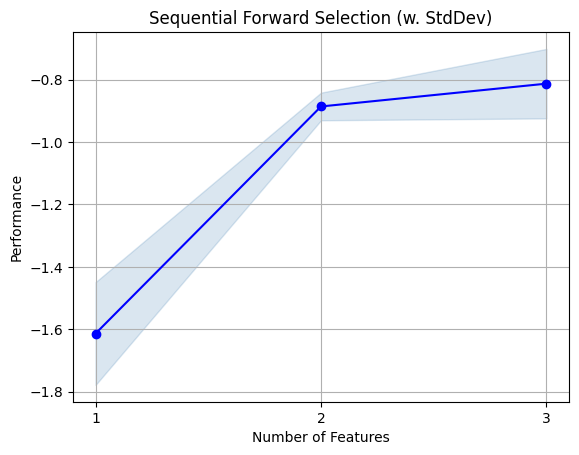

In [71]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [72]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', regressor)
])

rfe_sfs_pipeline.fit(X_train, y_train)

d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x000001EF928E75D0>),
                ('model', RandomForestRegressor())])

In [ ]:
#логируем модель с отобранными важными признаками с помощью mlxtend
predictions_sfs = rfe_sfs_pipeline.predict(X_test)

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_sfs)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_sfs)
metrics["mse"] = mean_squared_error(y_test, predictions_sfs)

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_sfs_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 13:51:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_sfs_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/ecd0c44e1f304d9c942c3eec4a310065.
2024/11/18 13:51:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


**HYPERPARAMS**


In [74]:
##Gridsearch
from sklearn.model_selection import  GridSearchCV

In [ ]:
#подбираем параметры
param_grid = {
    'model__max_depth': [i for i in range(1,10)],
    'model__n_estimators':[i for i in range(1,5)],
    'model__max_features':[i/10 for i in range(1,10)]
}

In [76]:
gs = GridSearchCV(rfe_skl_pipeline, param_grid, cv=2, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)
print("Лучшие гиперпараметры:", gs.best_params_)

d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn(
d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (113). n_quantiles is set to n_samples.
  warnings.warn(
d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn(
d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (113). n_quantiles is set to n_samples.
  warnings.warn(
d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_s

Лучшие гиперпараметры: {'model__max_depth': 9, 'model__max_features': 0.9, 'model__n_estimators': 4}


d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(


In [ ]:
#Обучаем и логируем модель с лучшими параметрами
regressor1=RandomForestRegressor(max_depth=9, max_features=0.8, n_estimators=4)
gs_pipeline  = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', regressor1)
])
gs_pipeline.fit(X_train,y_train)
predictions_gs = gs_pipeline.predict(X_test)
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_gs)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_gs)
metrics["mse"] = mean_squared_error(y_test, predictions_gs)

metrics
# Проведем стандартную проверку на тестовом множестве и залогируем run
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'gridsearch'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(gs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(gs_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(
2024/11/18 13:51:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run gridsearch at: http://127.0.0.1:5000/#/experiments/1/runs/2fe15852038d4bb3a4898c495bca0cd9.
2024/11/18 13:51:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


**optuna**


In [79]:
import optuna


In [84]:

def objective(trial):
    # предлагаем гиперпараметры
    depth = trial.suggest_int('depth', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)

    # создаём и обучаем модель
    opt_pipeline  = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn), 
        ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
        ('model', CatBoostRegressor(depth=depth, learning_rate=learning_rate, verbose=0))
    ])

    opt_pipeline.fit(X_train, y_train)

    # предсказываем и вычисляем RMSE
    preds = opt_pipeline.predict(X_test)
    mae =  mean_absolute_error(y_test, preds)   

    return mae
    

In [85]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# выводим результаты
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) 

[I 2024-11-18 13:55:19,885] A new study created in memory with name: no-name-bdc579b7-0ac8-4623-9a8a-05ea6e2de86d
d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(
[I 2024-11-18 13:55:21,097] Trial 0 finished with value: 0.6042726015997097 and parameters: {'depth': 8, 'learning_rate': 0.015343439977837908}. Best is trial 0 with value: 0.6042726015997097.
d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(
[I 2024-11-18 13:55:21,734] Trial 1 finished with value: 1.2340851590697997 and parameters: {'depth': 6, 'learning_rate': 0.0018202625089519084}. Best is trial 0 with value: 0.6042726015997097.
d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_qu

Number of finished trials: 10
Best trial: {'depth': 6, 'learning_rate': 0.038258858694007095}


In [ ]:
#Обучаем и логируем модель с параметрами, полученными с помощью optuna
opt_pipeline  = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', CatBoostRegressor(depth=6, learning_rate=0.03825))])

opt_pipeline.fit(X_train,y_train)
predictions_opt = opt_pipeline.predict(X_test)
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_opt)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_opt)
metrics["mse"] = mean_squared_error(y_test, predictions_opt)

metrics
# Проведем стандартную проверку на тестовом множестве и залогируем run
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'optuna'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(opt_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(opt_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')




d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(


0:	learn: 5.2441863	total: 639us	remaining: 639ms
1:	learn: 5.1202424	total: 1.21ms	remaining: 603ms
2:	learn: 5.0239808	total: 1.91ms	remaining: 636ms
3:	learn: 4.9021204	total: 2.53ms	remaining: 631ms
4:	learn: 4.7873818	total: 3.22ms	remaining: 641ms
5:	learn: 4.6803570	total: 3.83ms	remaining: 635ms
6:	learn: 4.5770279	total: 4.66ms	remaining: 661ms
7:	learn: 4.4722140	total: 5.33ms	remaining: 661ms
8:	learn: 4.3773935	total: 5.85ms	remaining: 645ms
9:	learn: 4.2685967	total: 6.38ms	remaining: 632ms
10:	learn: 4.1754863	total: 7.09ms	remaining: 637ms
11:	learn: 4.0954906	total: 7.63ms	remaining: 628ms
12:	learn: 4.0234450	total: 8.22ms	remaining: 624ms
13:	learn: 3.9369986	total: 8.81ms	remaining: 620ms
14:	learn: 3.8612757	total: 9.43ms	remaining: 619ms
15:	learn: 3.7740472	total: 9.97ms	remaining: 613ms
16:	learn: 3.6929035	total: 10.5ms	remaining: 606ms
17:	learn: 3.6202842	total: 11.1ms	remaining: 603ms
18:	learn: 3.5498900	total: 11.6ms	remaining: 598ms
19:	learn: 3.4836721	to

2024/11/18 13:57:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run optuna at: http://127.0.0.1:5000/#/experiments/1/runs/2e6e4eb44bb540e59af21b5c079c338b.
2024/11/18 13:57:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [ ]:
#выделение всей выборки
Y = df['target']
X = df.drop('target', axis=1)

In [ ]:
#использование лучшей моедли на ввсей выборке
opt_pipeline.fit(X,Y)
predictions_opt = opt_pipeline.predict(X_test)
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_opt)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_opt)
metrics["mse"] = mean_squared_error(y_test, predictions_opt)

metrics
# Проведем стандартную проверку на тестовом множестве и залогируем run
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'production'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(opt_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(opt_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')


d:\iis\lr2\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (301). n_quantiles is set to n_samples.
  warnings.warn(


0:	learn: 4.9551810	total: 543us	remaining: 543ms
1:	learn: 4.8290332	total: 1.28ms	remaining: 637ms
2:	learn: 4.7154500	total: 1.95ms	remaining: 648ms
3:	learn: 4.6039740	total: 2.53ms	remaining: 630ms
4:	learn: 4.4925699	total: 3.13ms	remaining: 622ms
5:	learn: 4.3798404	total: 3.69ms	remaining: 611ms
6:	learn: 4.2835137	total: 4.28ms	remaining: 608ms
7:	learn: 4.1753378	total: 4.87ms	remaining: 604ms
8:	learn: 4.0745114	total: 5.71ms	remaining: 629ms
9:	learn: 3.9832574	total: 6.41ms	remaining: 634ms
10:	learn: 3.8915195	total: 7.09ms	remaining: 638ms
11:	learn: 3.8098442	total: 7.58ms	remaining: 624ms
12:	learn: 3.7226304	total: 8.18ms	remaining: 621ms
13:	learn: 3.6443424	total: 8.77ms	remaining: 618ms
14:	learn: 3.5595281	total: 9.36ms	remaining: 615ms
15:	learn: 3.4814505	total: 9.94ms	remaining: 612ms
16:	learn: 3.4007722	total: 10.4ms	remaining: 600ms
17:	learn: 3.3508887	total: 10.7ms	remaining: 586ms
18:	learn: 3.2851398	total: 11.3ms	remaining: 583ms
19:	learn: 3.2165580	to

2024/11/18 14:00:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run production at: http://127.0.0.1:5000/#/experiments/1/runs/10608bdf12144244a280d59ca8ea6381.
2024/11/18 14:00:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.
